<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [2]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()


Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


## Data Augmentation in PyTorch

In [5]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        #transforms.RandAugment(),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ]
)

class MedicalDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

        print(f"Shape of image data: {self.y[1].shape}, Data type: {self.y[1].dtype}")
    def __len__(self):
        print(len(self.x))
        return len(self.x)

    def __getitem__(self, idx):

        return self.transform(Image.fromarray(self.x[idx],'RGB')), self.y[idx]




In [6]:
batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)

val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,  num_workers=1, pin_memory=True, persistent_workers=True)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 2550 and 600.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


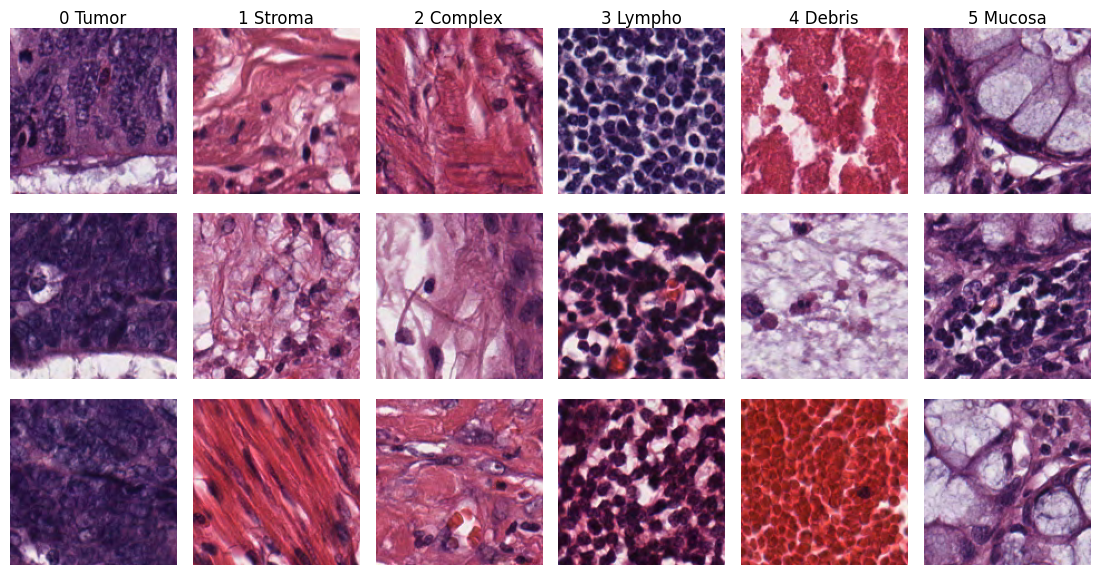

In [7]:
import matplotlib.pyplot as plt
import random

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 3

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 6))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)

    for i in range(samples_per_class):

        ax = axes[i, class_idx]
        #image, label = train_dataset[class_idx]
        img = x_train[random_indices[i]].numpy().transpose((1, 2, 0)) #image.permute(1, 2, 0).numpy()
        print(img.shape)
        img = img / img.max()
        ax.imshow(img)
        ax.axis('off')

        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

## B. Defining Neural Networks

In [8]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 channel, and using 3x3 kernels for simplicity, 150*150
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same') #150
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1) # 128*128 149
        #self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 128*128 149
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1) # 64*64 148
        #self.dropout2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64 148
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1) # 32*32 147
        #self.dropout3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64 148
        self.bn4 = nn.BatchNorm2d(32)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1) # 32*32 146

        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64 148
        self.bn5 = nn.BatchNorm2d(32)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1) # 32*32 145

        # Adjust flattened dimensions based on the output size of your last pooling layer
        flattened_dim = 145 * 145 * 32 #用算的 非任意; channel數 * 最後一層的 32 * 32  kernal size-1-原邊長150

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.fc2 = nn.Linear(32, 6)
        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        #x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        #x = self.dropout2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        #x = self.dropout3(x)


        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)


        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        x = F.relu(self.fc1(x))
        # x = nn.Dropout(0.5)
        return self.fc2(x)


## C. Training the Neural Network

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 120

# Change you model here
model =  ConvModel()# LinearModel(), ConvModel(), ConvModel_Re !!!!!!這裡 可直接從這裡改架構
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1
#nn.CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01) #, weight_decay=0.1
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
#lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        #labels = labels.float().unsqueeze(1)
        labels = labels.long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)  # torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)


    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            #labels = labels.float().unsqueeze(1)
            labels = labels.long()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)  # torch.sigmoid(outputs) > 0.5
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


ConvModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mo

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120, Train loss: 8.1998, Train acc: 19.29%, Val loss: 1.7949, Val acc: 16.67%, Best Val loss: 1.7949 Best Val acc: 16.67%
Epoch 2/120, Train loss: 1.7955, Train acc: 16.67%, Val loss: 1.7939, Val acc: 16.67%, Best Val loss: 1.7939 Best Val acc: 16.67%
Epoch 3/120, Train loss: 1.7947, Train acc: 15.49%, Val loss: 1.7931, Val acc: 16.67%, Best Val loss: 1.7931 Best Val acc: 16.67%
Epoch 4/120, Train loss: 1.7937, Train acc: 16.47%, Val loss: 1.7926, Val acc: 16.67%, Best Val loss: 1.7926 Best Val acc: 16.67%
Epoch 5/120, Train loss: 1.7932, Train acc: 16.24%, Val loss: 1.7922, Val acc: 16.67%, Best Val loss: 1.7922 Best Val acc: 16.67%
Epoch 6/120, Train loss: 1.7928, Train acc: 16.67%, Val loss: 1.7920, Val acc: 16.67%, Best Val loss: 1.7920 Best Val acc: 16.67%
Epoch 7/120, Train loss: 1.7925, Train acc: 16.24%, Val loss: 1.7918, Val acc: 16.67%, Best Val loss: 1.7918 Best Val acc: 16.67%
Epoch 8/120, Train loss: 1.7970, Train acc: 15.96%, Val loss: 1.7917, Val acc: 16.67%, Bes

### Visualizing model performance

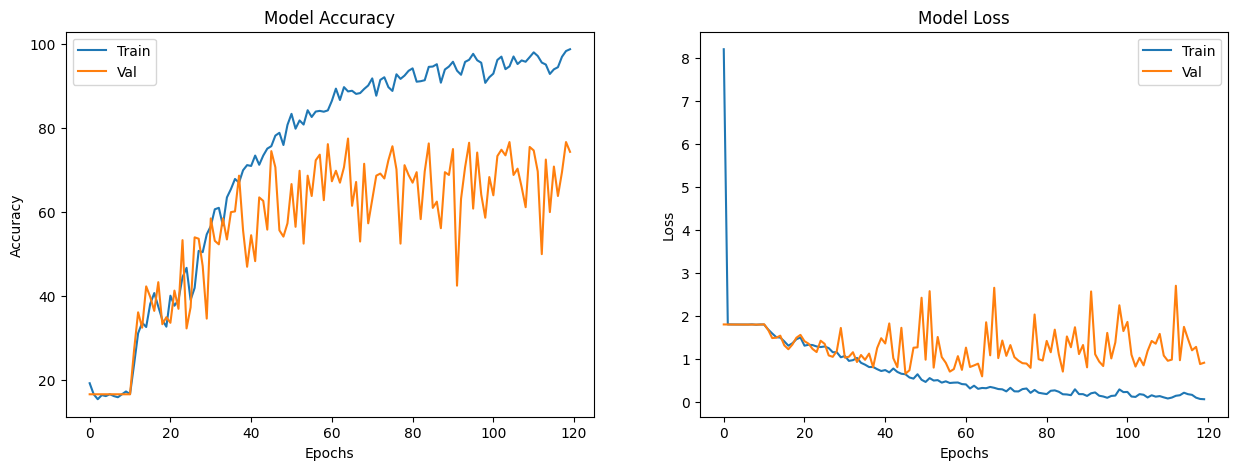

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Process Test Dataset

In [14]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [15]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 32

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [16]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 80.16666666666667%
